<a href="https://colab.research.google.com/github/leninathikam/intro2DS/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P2 - Statistics + Visualization


This project is intended to give you experience with statistics and working with a large data set.





## Project Setup

You should use the following modules in this assignment and not need any additional modules.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import os
import re
import platform
import sys
import importlib
from packaging.version import Version, parse

# Flight Delays

Suppose the Houghton County Airport (CMX) is ready to renew its passenger airplane contract.  Airport officials and interested passengers would like to select an airline and connecting city that has reliable service.  *Currently, CMX is being served by United Airlines through Chicago-O'hare (ORD); it has been served by Delta in the past with connections to Minneapolis-St. Paul (MSP).*

In order to make an informed decision, you have been tasked to look at flight delay statistics for two potential connector airports:

* Chicago - O'hare (ORD)
* Detroit (DTW)

The data you are provided comes from the US Department of Transportation's [Bureau of Transportation Statistics (BTS)](https://www.bts.gov).  In particular, it comes from the Reporting Carrier On-Time Performance data tables:  
https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr&V0s1_b0yB=D

Information on the variables can be found in the Field Information:  
https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ


The data is structured with the following elements:

* "YEAR"
* "MONTH"
* "DAY_OF_MONTH"
* "OP_UNIQUE_CARRIER" - Unique Carrier Code
* "TAIL_NUM" - Tail number
* "OP_CARRIER_FL_NUM" - Flight number
* "ORIGIN" - Origin Airport code
* "DEST" - Destination Airport code
* "CRS_DEP_TIME" - Computer Reservation System Departure Time (local time: hhmm)
* "DEP_TIME" - Actual Departure Time (local time: hhmm)
* "DEP_NEXT_DAY" - the flight departed on the: (scheduled day = 0), (next day = 1), (following day = 2), or (day before  = -1)
* "CRS_ARR_TIME" - Computer Reservation System Arrival Time (local time: hhmm)
* "ARR_TIME" - Actual Arrival Time
* "ARR_NEXT_DAY" - the flight arrived on the: (scheduled day = 0), (next day = 1), (following day = 2), or (day before  = -1)
* "CANCELLED" - Cancelled Flight Indicator (1 = Yes)
* "DIVERTED" - Diverted Flight Indicator (1 = Yes)

You have access to 2 years of data Jan 2022 - Dec 2023.

The data has also been restricted to several major carriers and their regional services:

| Airline Code | Airline Name | Regional Partner |
|--------------|--------------|------------------|
| UA      | United Airlines   | NA  |
| DL      | Delta Airlines    | NA  |
| OO      | Skywest Airlines  | United  |
| 9E      | Endeavor Air      | Delta     |


## Access the Data

The data is available on [Kaggle](https://www.kaggle.com/datasets/lebrown/un5550-fa24-p2/data)

Once you download the data make sure it is saved in your project directory:

```
class-folder/
    p2/
        flight-final.csv
        img/
        p2.ipynb
```

<!-- BEGIN QUESTION -->

## Q0 - Setup

The following code checks to make sure your notebook is running on Gradescope, the cloud, or linux lab machines.

While you may develop on your own machines or places like Colab or Github, you should run your final submission on the campus Linux machines using the `un5550fa24` environment.


_Type your answer here, replacing this text._

In [3]:
# DO NOT CHANGE THIS CODE

# flag if notebook is running on Gradescope
if re.search(r'amzn', platform.uname().release):
    GS = True
else:
    GS = False

# flag if notebook is running on Colaboratory
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines.
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28|coc-15954-m)', cname):
    LLM = True
else:
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

System: GS - False, COLAB - True, LLM - False


In [4]:
# DO NOT CHANGE THIS CODE
pver = sys.version
print(pver)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [5]:
# DO NOT CHANGE THIS CODE
env2 =!conda info | grep 'active env'
print(env2)

['/bin/bash: line 1: conda: command not found']


In [8]:
# DO NOT CHANGE THIS CODE
OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "x1b[41m[FAIL]\x1b[0m"

def import_version(pkg, req_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        ver = mod.__version__
        if Version(ver) != req_ver:
            print(FAIL, "%s version %s required, but %s installed."
                  % (lib, req_ver, ver))
        else:
            print(OK, '%s version %s' % (pkg, ver))
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return (mod, Version(ver), req_ver)

requirements = {'numpy': parse("2.1.0"), 'scipy': parse("1.14.1"),
                'matplotlib': parse("3.9.2"), 'pandas': parse("2.2.2"),
                'seaborn': parse('0.13.2'),
                'sklearn': parse("1.5.1")
                }

pks = []
for lib, required_version in list(requirements.items()):
    pks.append(import_version(lib, required_version))

x1b[FAIL] numpy version 2.1.0 required, but 1.26.4 installed.
x1b[FAIL] scipy version 1.14.1 required, but 1.13.1 installed.
x1b[FAIL] matplotlib version 3.9.2 required, but 3.7.1 installed.
[ OK ] pandas version 2.2.2
[ OK ] seaborn version 0.13.2
x1b[FAIL] sklearn version 1.5.1 required, but 1.5.2 installed.


<!-- END QUESTION -->

## Q1 - Load Data

Read in the data.    

Set the column names to be: `year`, `month`, `day`, `carrier`, `tailNum`, `flNum`, `origin`, `dest`, `crsDepTime`, `actDepTime`, `depNextDay`, `crsArrTime`, `actArrTime`, `arrNextDay`, `cancelled`, `diverted`

You do not need to do any special preprocessing or changing of the data types, we will be during specific processing of the data in the coming questions.

In [16]:
# Read in data, set DataFrame columns to names above

flights = pd.read_csv("flight-final.csv")
flights.columns = ['year', 'month', 'day', 'carrier', 'tailNum', 'flNum', 'origin', 'dest', 'crsDepTime', 'actDepTime', 'depNextDay', 'crsArrTime', 'actArrTime', 'arrNextDay', 'cancelled', 'diverted']

flights.head()

,year,month,day,carrier,tailNum,flNum,origin,dest,crsDepTime,actDepTime,depNextDay,crsArrTime,actArrTime,arrNextDay,cancelled,diverted
0,2022,12,1,9E,N133EV,4915,DSM,DTW,620,616.0,0,909,902.0,0,0.0,0.0
1,2022,12,1,9E,N133EV,5015,DSM,DTW,1405,1401.0,0,1651,1635.0,0,0.0,0.0
2,2022,12,1,9E,N133EV,5042,DTW,DSM,1215,1207.0,0,1320,1259.0,0,0.0,0.0
3,2022,12,1,9E,N134EV,4883,DTW,DSM,1950,1958.0,0,2054,2051.0,0,0.0,0.0
4,2022,12,1,9E,N134EV,5378,SYR,DTW,1710,1700.0,0,1854,1823.0,0,0.0,0.0


In [17]:
grader.check("q1")

NameError: name 'grader' is not defined

## Aside : Style

In the following questions you are going to be chaining together many expressions, perhaps creating code that is longer than 79 characters long (the maximum suggested by the [PEP-8 style guides](https://peps.python.org/pep-0008/#maximum-line-length)).

    The preferred way of wrapping long lines is by using Python’s implied line
    continuation inside parentheses, brackets and braces. Long lines can be broken
    over multiple lines by wrapping expressions in parentheses. These should be
    used in preference to using a backslash for line continuation.
    
Using parenthesis surrounding code make it possible to break the code into multiple lines for readability.

Here are some examples:

In [18]:
temp = (flights[(flights['dest'] == 'CMX') |
                (flights['origin'] == 'CMX')])

In [19]:
temp = (
    flights[(flights['dest'] == 'CMX') |
            (flights['origin'] == 'CMX')]
)

In [20]:
temp = (flights
        .groupby('month')['diverted']
        .sum())

In [21]:
temp = (
    flights
    .groupby('month')['diverted']
    .sum()
)

## Q2 - Explore Data

Let's start to explore the data.  

In [22]:
print("Flight data: %8d rows,  %d columns" % (flights.shape[0], flights.shape[1]))

Flight data:   919839 rows,  16 columns


We want to remove flights that were cancelled or diverted from the rest of our analysis.

But, first let's examine cancelled or diverted flights.



### Q2a - Diverted and Cancelled Flights

You will need to determine the number of diverted flights, `num_divert` and the number of cancelled flights, `num_cancel`.

Next, determine the destination airport(s), by their code, with the highest proportion of diverted and cancelled flights `airport_highest_prop_divert` and `airport_highest_prop_cancel`.

In [23]:
# num_divert - number of flights that were diverted.
# num_cancel - number of flights that were cancelled
num_divert = flights['diverted'].sum()
num_cancel = flights['cancelled'].sum()
print('Num. of diverted flights:  %7d\nNum. of cancelled flights: %7d\n' % \
      (num_divert, num_cancel))

Num. of diverted flights:     1872
Num. of cancelled flights:   15264



In [25]:

divert_prop = flights.groupby('dest')['diverted'].sum() / flights.groupby('dest')['diverted'].count()
cancel_prop = flights.groupby('dest')['cancelled'].sum() / flights.groupby('dest')['cancelled'].count()


airport_highest_prop_divert = divert_prop.idxmax()

airport_highest_prop_cancel = cancel_prop.idxmax()


print('Airport with highest proportion of flights diverted:  %s' % airport_highest_prop_divert)
print('Airport with highest proportion of flights cancelled: %s' % airport_highest_prop_cancel)

Airport with highest proportion of flights diverted:  ASE
Airport with highest proportion of flights cancelled: CMX


In [26]:
grader.check("q2a")

NameError: name 'grader' is not defined

<br>

Do these values make sense?  You can lookup airport codes on Google.

<br>

**Note** the local airport in Houghton / Hancock is `CMX`.

### Q2b - Filter Cancelled and Diverted Flights

Now, let's remove the cancelled and diverted flights from further analysis.

After removing both flights, reset the index on the remaining flights in the `flights` DataFrame.

In [27]:
# Remove the cancelled and diverted flights.
# Then, reset the index of the flights DataFrame
flights = flights[(flights['cancelled'] == 0) & (flights['diverted'] == 0)]

flights = flights.reset_index(drop=True)

print("Flight data:   %8d rows" % flights.shape[0])

Flight data:     902703 rows


In [28]:
grader.check("q2b")

NameError: name 'grader' is not defined

### Q2c - Flights at `DTW` and `ORD`

Report the number of flights departing and arriving from each of the two airports under study: `DTW` and `ORD`.

In [29]:
# numArrDTW - number of flights arriving at DTW
# numDepDTW - number of flights departing DTW
numArrDTW = flights[flights['dest'] == 'DTW'].shape[0]
numDepDTW = flights[flights['origin'] == 'DTW'].shape[0]
print("DTW flights:   %7d arrivals,  %7d departures" % (numArrDTW, numDepDTW))

DTW flights:    192689 arrivals,   192577 departures


In [30]:
# numArrORD - number of flights arriving at ORD
# numDepORD - number of flights departing ORD
numArrORD = flights[flights['dest'] == 'ORD'].shape[0]
numDepORD = flights[flights['origin'] == 'ORD'].shape[0]
print("ORD flights:   %7d arrivals,  %7d departures" % (numArrORD, numDepORD))

ORD flights:    266762 arrivals,   266971 departures


*Note*: The number of flights arriving and departing from the two airports exceeds the total number of flights, because flights between the 2 airports are counted twice.

In [31]:
grader.check("q2c")

NameError: name 'grader' is not defined

## Q3 - Time Information and Flight Delays.

Both the departure and arrival times were read in as integers or floating-point numbers in local time format: `hhmm`.

### Question 3a - Extract Hour and Minutes

Write two functions, `extract_hour` and `extract_mins` that converts the local time to hours and minutes, respectively.

*Hint:* You may want to use modular arithmetic and integer division.

Notes:

* The function should work on a single value passed or a Series passed in as an argument.
* The function should not have a `for` loop, if it does you will lose points!

In [32]:
def extract_hour(time):
    """
    Extract hour information from the time given in hhmm format.

    Input:
        time (float64 or int64): Series of time given in hhmm format.
          Takes on values in 0.0-2400.0 in float64 representation or
          values in 0-2400 in int64 representation

    Returns:
        array (float64 or int64): Series of same dimension as input of hours
          values should be 0-24, i.e., 24-hour day format

    Example: 1303 should return 13
    >>> extract_hour(1303.0)
    13
    """
    hours = (time // 100).astype(int)

    return hours

In [33]:
def extract_min(time):
    """
    Extract minute information from the time given in hhmm time.

    Input:
        time (float64 or int64): Series of time given in hhmm format.
          Takes on values in 0.0-2400.0 in float64 representation or
          values in 0-2400 in int64 representation

    Returns:
        array (float64 or int64): Series of same dimension as input of minutes.
          values should be 0-59

    Example: 1303 should return 3
    >>> extract_mins(1303.0)
    3
    """
    mins = (time % 100).astype(int)
    return mins

Here are some examples of usage:

```
>>> extract_hour(1450)
>>> extract_hour(flights['actDepTime'][100:200])
>>> extract_hour(flights['crsDepTime'])
>>> extract_min(1450)
>>> extract_min(flights['actDepTime'][100:200])
>>> extract_min(flights['crsDepTime'])
```

In [ ]:
grader.check("q3a")

### Q3b - Calculate Time in Minutes

Convert a time formatted in `hhmm` time in the number of minutes.    

For example, the following times in `hhmm` format converted to minutes are: `1005` is 605 minutes and `837` is 517 minutes and `1524` is 924 minutes.

This function `convert_to_minutes` function, should make use of the two functions you wrote above: `extract_hour` and `extract_min`.

Comment:

* The function should work on a single value passed or a Series passed in as an argument.
* The function should not have a `for` loop, if it does you will lose points!
* The function should use the functions `extract_hour` and `extract_min`.

In [34]:
def convert_to_minutes(time):
    """
    Converts time in hhmm format to number of minutes

    Input:
       time (float64 or int64): Series of time given in hhmm format.
          Takes on values in 0.0-2400.0 in float64 representation or
          values in 0-2400 in int64 representation

    Returns:
        array (float64 or int64): Series of same dimension as input with
           total mins


    Example: 1303 is converted to 783
    >>> convert_to_minutes(1303.0)
    783.0
    """
    # make use of the functions you wrote above: extract_hour, extract_min
    minutes = extract_hour(time) * 60 + extract_min(time)
    return minutes

In [35]:
grader.check("q3b")

NameError: name 'grader' is not defined

### Q3c - Calculate Delayed Flights

You will add two new columns to the `flights` DataFrame that will contain the departure delay `depDelay` and arrival delay `arrDelay`.

To help answer this question, implement the helper functions, `calc_time_diff`.  Make use of the functions above, e.g., `convert_to_minutes`.


*Be careful for handling flights that that did not leave on their scheduled day indicated in the `depNextDay` and `arrNextDay` columns.*  
These two variables are encoded as:
* 0, left/arrived on scheduled day
* -1, left/arrived on the day before scheduled day
* 1, left/arrived 1 day after scheduled day
* 2, left/arrived 2 days after scheduled day


Note, you can have *negative* flight delays for flights that leave / arrive early.

Notes:

* The function should work on Series passed in as an argument.
* The function should not have a `for` loop, if it does you will lose points!

In [36]:
def calc_time_diff(x, y, nextDay):
    """
    Calculate the time difference, y - x, accounting for nextDay changes.

    Input:
        x,y (float64 or int64): Series of scheduled time given in hhmm format.
          Takes on values in 0.0-2400.0 due to float64 representation or
          values in 0-2400 in int64 representation
        nextDay (int): Series of next day indicator, takes on values: -1, 0, 1, 2

    Returns:
        array (float64): Series of input dimension with delay time


    Example: 1303 is converted to 783
             1305 is converted to 785
    >>> calc_time_diff(pd.Series([1303]), pd.Series([1305]), pd.Series([0]))
    2

    Example: 2320.0 is converted to 1400.0
               37.0 is converted to    37.0
    >>> calc_time_diff(pd.Series([2320.0]), pd.Series([37.0]), pd.Series([1]))
    77.0
    """
    # make use of the convert_to_minutes function

    diff = convert_to_minutes(y) - convert_to_minutes(x) + nextDay * 24 * 60

    return diff

In [37]:
flights['depDelay'] = calc_time_diff(flights['crsDepTime'], flights['actDepTime'], flights['depNextDay'])
flights['arrDelay'] = calc_time_diff(flights['crsArrTime'], flights['actArrTime'], flights['arrNextDay'])

In [38]:
grader.check("q3c")

NameError: name 'grader' is not defined

## Q4 - Patterns of Delays

Next, you will examine if there are any patterns in the delays.  


### Q4a - Delay Statistics

Present the mean, standard deviation, and median for departure and arrival delays for each airport, `DTW` and `ORD` as a destination in a DataFrame.

Repeat the results where each airport, `DTW` and `ORD`, is the origin.

**NOTE: all the meaningful autograded tests are hidden for this problem.**

**Hint** You should consider using `groupby`

The DataFrame you create should look something like (note the values are not correct):

<img src="img/q4a_sample.png" width="60%">

In [39]:
# Calculate the mean, std, and median Depature Delay for flights leaving DTW/ORD
# Calculate the mean, std, and median Delay for flights arriving at DTW/ORD
# Report in requested DataFrames

destDelays = flights.groupby('dest').agg(
    arrDelayMean=('arrDelay', 'mean'),
    arrDelayStd=('arrDelay', 'std'),
    arrDelayMedian=('arrDelay', 'median'),
    depDelayMean=('depDelay', 'mean'),
    depDelayStd=('depDelay', 'std'),
    depDelayMedian=('depDelay', 'median')
)
destDelays = destDelays.loc[['DTW', 'ORD']]  # Select only DTW and ORD

originDelays = flights.groupby('origin').agg(
    arrDelayMean=('arrDelay', 'mean'),
    arrDelayStd=('arrDelay', 'std'),
    arrDelayMedian=('arrDelay', 'median'),
    depDelayMean=('depDelay', 'mean'),
    depDelayStd=('depDelay', 'std'),
    depDelayMedian=('depDelay', 'median')
)
originDelays = originDelays.loc[['DTW', 'ORD']]  # Select only DTW and ORD

print(destDelays)
print(originDelays)

      arrDelayMean  arrDelayStd  arrDelayMedian  depDelayMean  depDelayStd  \
dest                                                                         
DTW       2.787819    59.409565            -9.0      9.894332    57.977394   
ORD       5.694147    64.246408            -8.0     11.945618    62.684013   

      depDelayMedian  
dest                  
DTW             -3.0  
ORD             -3.0  
        arrDelayMean  arrDelayStd  arrDelayMedian  depDelayMean  depDelayStd  \
origin                                                                         
DTW         2.327043    49.265181            -8.0      9.997700    47.026467   
ORD         5.302535    51.318237            -7.0     11.746635    49.081207   

        depDelayMedian  
origin                  
DTW               -2.0  
ORD               -2.0  


In [40]:
grader.check("q4a")

NameError: name 'grader' is not defined

<!-- BEGIN QUESTION -->

### Q4b - Distribution of Departure Delays

Let's look at the distribution of departure delays for flights leaving `DTW` and `ORD`.

Create overlapping density plots to examine these distributions. Only show the delays from -25 to 50 minutes.

**Hint** Try using seaborns `kdeplot`

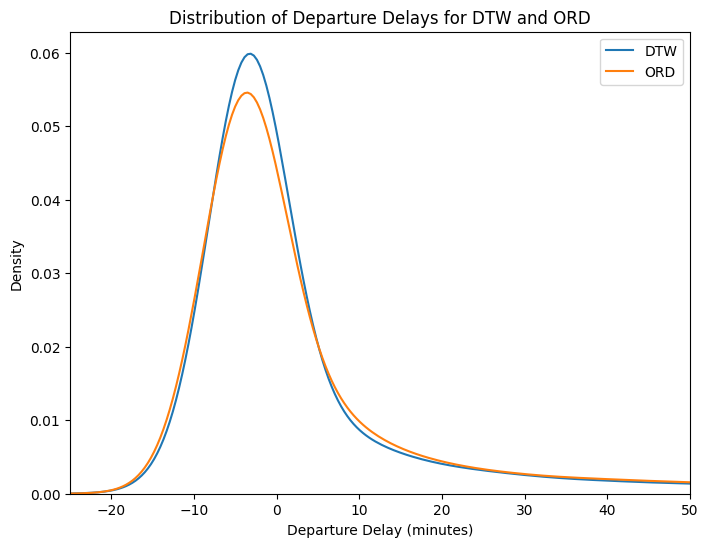

In [41]:
dtw_flights = flights[flights['origin'] == 'DTW']
ord_flights = flights[flights['origin'] == 'ORD']

# Create density plots
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.kdeplot(dtw_flights['depDelay'], label='DTW', clip=(-25, 50))
sns.kdeplot(ord_flights['depDelay'], label='ORD', clip=(-25, 50))

# Customize the plot
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Departure Delays for DTW and ORD')
plt.legend()
plt.xlim(-25, 50)  # Set x-axis limits

# Show the plot
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4c - Departure Delays by Day of Week

Let's examine if the departure delays differ by which day a flight is scheduled to leave.

Create a bar chart showing the mean departure delay for each day of the week. Report mean delays for Sun., Mon., Tues., ...

In order to get the day of the week, create a two new columns `dateVal` that is a datetime object of the date information of the flight.  Also, create a column `dayOfWeek` that encodes the day of the week for the flight.  You can make use of functions to convert datetime to day of the week.

We are looking at departure delays for flights leaving from ORD.


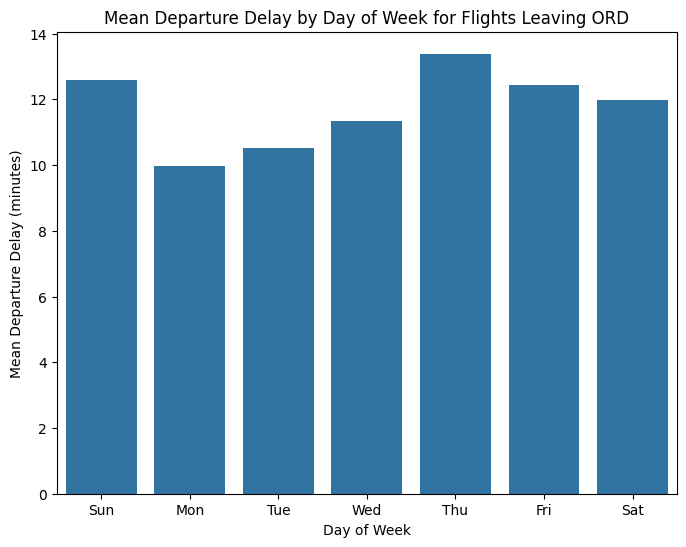

In [42]:
# Look at departure delays for flights leaving ORD
# Create a new column "dateVal" with a datetime object that may be useful
#  for this questions.  Also, add a column for "dayOfWeek"

# Create a bar chart of the mean `depDelay` by day of the week: Mon., Tues., ...


flights['dateVal'] = pd.to_datetime(flights[['year', 'month', 'day']])

# Create 'dayOfWeek' column (0=Sunday, 1=Monday, ..., 6=Saturday)
flights['dayOfWeek'] = flights['dateVal'].dt.dayofweek

# Filter for flights departing from ORD
ord_flights = flights[flights['origin'] == 'ORD']

# Calculate mean departure delay by day of week
mean_delays = ord_flights.groupby('dayOfWeek')['depDelay'].mean()

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=mean_delays.index, y=mean_delays.values)

# Customize the plot
plt.xlabel('Day of Week')
plt.ylabel('Mean Departure Delay (minutes)')
plt.title('Mean Departure Delay by Day of Week for Flights Leaving ORD')
plt.xticks(ticks=range(7), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

# Show the plot
plt.show()


In [ ]:
grader.check("q4c")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q4d - Dept. Delays by Month

Next, let's examine if the depature delays differ by month of the year.

Create a bar chart showing the mean departure delay for each month of the year (Jan, Feb, Mar, Apr, ...)

We again are looking at departure delays for flights leaving from ORD.

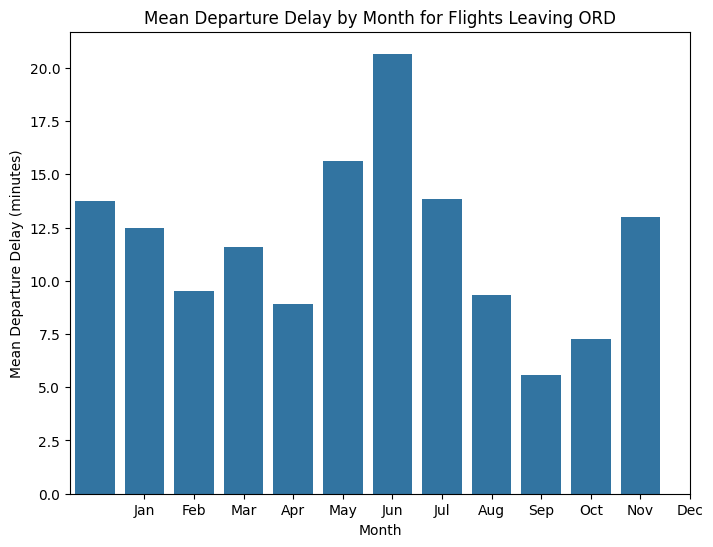

In [43]:
# Create a bar plot with the mean dep. delay for each month.
ord_flights = flights[flights['origin'] == 'ORD']

# Calculate mean departure delay by month
mean_delays_by_month = ord_flights.groupby('month')['depDelay'].mean()

# Create bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.barplot(x=mean_delays_by_month.index, y=mean_delays_by_month.values)

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Mean Departure Delay (minutes)')
plt.title('Mean Departure Delay by Month for Flights Leaving ORD')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.show()

<!-- END QUESTION -->

### Q4e - Most Delayed Routes

Let's examine the routes that are most delayed.

Report out a DataSeries, `most_delay_routeA`,  with the airport as it's index and the value the mean arrival delay, only consider flights departing from `ORD` and routes that have at least 200 flights.

Sort the DataSeries in descending order.


Repeat the analysis for `DTW`, but use departure delay, report results in `most_delay_routeB` DataSeries.


In [48]:
# Create a line chart plotting the mean dep. delay over time for each month
#  of the 6 years


# For ORD (arrival delay)
most_delay_routeA = (flights[flights['origin'] == 'ORD']
                      .groupby('dest')['arrDelay']
                      .agg(['mean', 'count'])
                      .loc[lambda x: x[('count')] >= 200]  # Filter based on count
                      .sort_values(by=[('mean')], ascending=False)  # Sort by mean
                      [('mean')])  # Select the mean column

# For DTW (departure delay)
most_delay_routeB = (flights[flights['origin'] == 'DTW']
                      .groupby('dest')['depDelay']
                      .agg(['mean', 'count'])
                      .loc[lambda x: x[('count')] >= 200]  # Filter based on count
                      .sort_values(by=[('mean')], ascending=False)  # Sort by mean
                      [('mean')])  # Select the mean column

In [49]:
most_delay_routeA

,mean
dest,
JST,27.169935
ASE,23.138562
AVP,18.191318
JLN,16.776632
ABE,14.748982
...,...
SJC,-3.222527
MKG,-5.089041
SNA,-5.346746


In [51]:
# Calculate the mean, std, and median Depature Delay for flights leaving DTW/ORD
# Calculate the mean, std, and median Delay for flights arriving at DTW/ORD
# Report in requested DataFrames

delay_routes = flights.groupby(['origin', 'dest'])[['depDelay', 'arrDelay']].agg(['mean', 'std', 'median', 'count'])

most_delay_routeA = (delay_routes
                      .loc[delay_routes[('arrDelay', 'count')] >= 200, ('arrDelay', 'mean')]
                      .sort_values(ascending=False))

most_delay_routeB = (delay_routes
                      .loc[delay_routes[('depDelay', 'count')] >= 200, ('depDelay', 'mean')]
                      .sort_values(ascending=False)
)

In [52]:
delay_routes.loc[(delay_routes[('depDelay', 'count')] > 200)].shape

(470, 8)

In [53]:
grader.check("q4e")

NameError: name 'grader' is not defined

### Q4f - Delays by Carrier

Because `ORD` is a United Hub and `DTW` is a Delta Hub we expect to see the delays grouped by airport may also be similar to the delays grouped by carrier.  Let's examine this.

Consider all flights, not just those arriving or departing from `ORD` and `DTW`.  Report out the mean, standard deviation, and median arrival and departure delays for each carrier in a DataFrame.

Label the carriers with their name, not code.

| Airline Code | Airline Name | Regional Partner |
|--------------|--------------|------------------|
| UA      | United Airlines   | NA  |
| DL      | Delta Airlines    | NA  |
| OO      | Skywest Airlines  | United  |
| 9E      | Endeavor Air      | Delta     |

The DataFrame `carrierDelays` has columns: `carrier`, `arrDelayMean`, `arrDelayStd`, `arrDelayMedian`,
`depDelayMean`, `depDelayStd`, `depDelayMedian`

Sort the DataFrame by increasing mean arrival  delays.

In [54]:
# Create carrierDelays DataFrame
carrierDelays = flights.groupby('carrier').agg(
    arrDelayMean=('arrDelay', 'mean'),
    arrDelayStd=('arrDelay', 'std'),
    arrDelayMedian=('arrDelay', 'median'),
    depDelayMean=('depDelay', 'mean'),
    depDelayStd=('depDelay', 'std'),
    depDelayMedian=('depDelay', 'median')
)

# Rename carrier codes to airline names
carrier_mapping = {
    'UA': 'United Airlines',
    'DL': 'Delta Airlines',
    'OO': 'Skywest Airlines',
    '9E': 'Endeavor Air'
}
carrierDelays['carrier'] = carrierDelays.index  # Add carrier column
carrierDelays['carrier'] = carrierDelays['carrier'].map(carrier_mapping)  # Map codes to names
carrierDelays = carrierDelays.set_index('carrier')  # Set carrier as index

# Sort by increasing mean arrival delays
carrierDelays = carrierDelays.sort_values(by='arrDelayMean')

# Display the DataFrame
carrierDelays

,arrDelayMean,arrDelayStd,arrDelayMedian,depDelayMean,depDelayStd,depDelayMedian
carrier,,,,,,
Endeavor Air,-0.640469,49.251744,-10.0,6.041726,47.087092,-4.0
Delta Airlines,1.954484,50.207973,-9.0,9.891461,48.154017,-2.0
United Airlines,4.177474,51.646764,-7.0,11.224120,49.727298,-2.0
Skywest Airlines,7.926424,68.812359,-7.0,13.294421,67.310415,-3.0


In [ ]:
grader.check("q4f")

## Bonus

Find the tail number of the top ten planes (identified by `tailNum`), with the worst departure delays (average delays).  You may find `drop_duplicates`, `agg`, and `sort_values` helpful.

Consider only planes that have made at least 10 flights.

Report out results in a DataFrame, `topDelayed`, the tail number `tailNum`, number of flights `num`, and the mean delay `mnDelay`.

In [55]:
# Find the tail numbers of the planes with the worst mean dep. delays.
# Store the tail number "tailNum", number of flights "num", and
#   mean delay "mnDelay" in a DataFrame


# Calculate mean departure delay and flight count for each tail number
topDelayed = flights.groupby('tailNum')['depDelay'].agg(['mean', 'count'])

# Rename columns for clarity
topDelayed = topDelayed.rename(columns={'mean': 'mnDelay', 'count': 'num'})

# Filter for planes with at least 10 flights
topDelayed = topDelayed[topDelayed['num'] >= 10]

# Sort by mean departure delay in descending order
topDelayed = topDelayed.sort_values(by='mnDelay', ascending=False)

# Reset index to access tailNum as a column
topDelayed = topDelayed.reset_index()

# Select the top 10 planes
topDelayed = topDelayed.head(10)

# Display the DataFrame
topDelayed

,tailNum,mnDelay,num
0,N507DZ,129.727273,11
1,N670UA,117.727273,11
2,N3730B,104.000000,16
3,N67052,97.650000,20
4,N510SY,94.202899,69
5,N3752,85.800000,15
6,N521DT,77.100000,10
7,N377DA,76.357143,14
8,N59053,75.071429,14
9,N641UA,72.611111,36


In [56]:
grader.check("b1")

NameError: name 'grader' is not defined

## Congratulations! You have finished P2!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the P2 assignment on Gradescope, Gradescope will automatically submit a PDF file with your some of your answers to the P2 - Figures assignment (making them easier to grade).

**Important**: Please check that your responses were generated and submitted correctly to the P2 - Figures Assignment.

**You are responsible for ensuring your submission follows our requirements and that the PDF for P2- Figures answers was generated/submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with the submission, contact course staff well-ahead of the deadline.

Make sure you have run all cells in your notebook **in order** before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()